<a href="https://colab.research.google.com/github/hugosousa111/analyze-IBM-HR-dataset/blob/main/Depart_RH_dataset_IBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudos sobre a base IBM HR Analytics Employee Attrition & Performance


- Departamento de Recursos Humanos
- Aplicação de técnicas de pré-processamento e exploração de algoritmos de aprendizagem de máquina para prever funcionários que são mais prováveis de sair de um emprego
- Informações:
    - Base de dados: https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset
    - Cálculo de salário: https://www.mom.gov.sg/employment-practices/salary/monthly-and-daily-salary e https://sprout.zendesk.com/hc/en-us/articles/360030922133-How-to-Calculate-for-the-Daily-Rate-from-Your-Monthly-Salary-
    - Stock: https://www.moneyunder30.com/employee-stock-options#:~:text=Typically%20they%20are%20granted%20to,a%20specific%20period%20of%20time.




## Bibliotecas e dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [73]:
# Métodos de classificação
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import tensorflow as tf # redes neurais

# Métricas
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report

# Salvar o modelo
import pickle

In [3]:
# A base pode ser adicionada no ambiente do colab ou usar o link do github
#df = pd.read_csv('/content/Human_Resources.csv')
df = pd.read_csv('https://raw.githubusercontent.com/hugosousa111/analyze-IBM-HR-dataset/main/dataset/Human_Resources.csv')
df.shape

(1470, 35)

## Informações sobre os dados da base

In [4]:
# Primeiras amostras da base
df.head(3)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0


In [5]:
# Informações, inclusive se tem algum dado null
df.info()
# não tem valores nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [6]:
# Algumas estatísticas básicas sobre a base
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [7]:
# O atributo Attrition é o que eu quero prever

# Tranformação: 
# Yes(Y) => 1 (é próvavel que mude de empresa)
# No(N) => 0 (não é próvavel que mude de empresa)

df['Attrition'] = df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)
df['OverTime'] = df['OverTime'].apply(lambda x: 1 if x == 'Yes' else 0)
df['Over18'] = df['Over18'].apply(lambda x: 1 if x == 'Y' else 0)

df.head(3)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,1,1,11,3,1,80,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,1,0,23,4,4,80,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,1,1,15,3,2,80,0,7,3,3,0,0,0,0


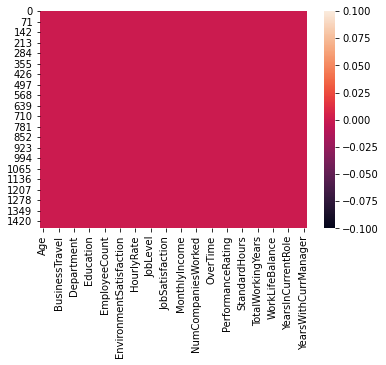

In [8]:
# Heatmap para mostrar onde estariam os dados nulos, se tivesse
sns.heatmap(df.isnull());#, cbar = False);

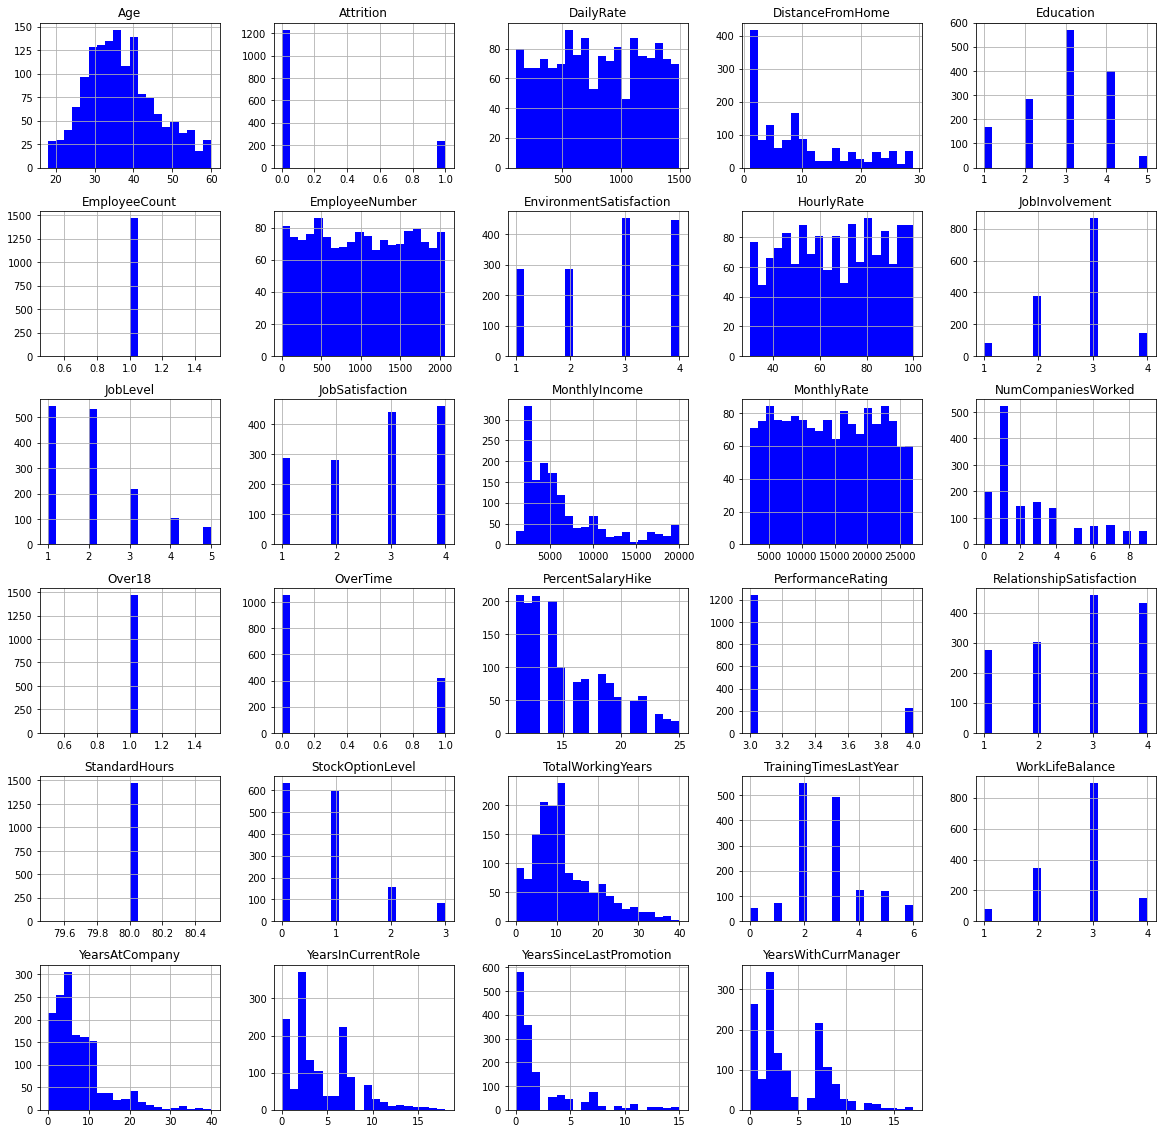

In [9]:
# Histograma de cada atributo da base
df.hist(bins = 20, figsize=(20,20), color = 'b');

In [10]:
# Excluindo atributos
# Os atributos EmployeeCount, StandardHours, Over18 só tem um valor
# e EmployeeNumber é só um contador

df.drop(['EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber'], axis = 1, inplace=True)

df.shape

(1470, 31)

In [11]:
# Separando em duas bases, daqueles que vão sair da empresa e os que não vão sair
sai_df = df[df['Attrition'] == 1]
nSai_df = df[df['Attrition'] == 0]

In [12]:
print('Total de funcionários = ', len(df))
print('Número de funcionários que saíram da empresa = ', len(sai_df))
print('% de funcionários que saíram da empresa = ', (len(sai_df) / len(df)) * 100)
print('Número de funcionários que ficaram na empresa = ', len(nSai_df))
print('% de funcionários que ficaram na empresa = ', (len(nSai_df) / len(df)) * 100)

Total de funcionários =  1470
Número de funcionários que saíram da empresa =  237
% de funcionários que saíram da empresa =  16.122448979591837
Número de funcionários que ficaram na empresa =  1233
% de funcionários que ficaram na empresa =  83.87755102040816


In [13]:
# Estátiticas sobre os funcionários que saíram
sai_df.describe()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,237.000000,237.0,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000
mean,33.607595,1.0,750.362869,10.632911,2.839662,2.464135,65.573840,2.518987,1.637131,2.468354,4787.092827,14559.308017,2.940928,0.535865,15.097046,3.156118,2.599156,0.527426,8.244726,2.624473,2.658228,5.130802,2.902954,1.945148,2.852321
std,9.689350,0.0,401.899519,8.452525,1.008244,1.169791,20.099958,0.773405,0.940594,1.118058,3640.210367,7208.153264,2.678519,0.499768,3.770294,0.363735,1.125437,0.856361,7.169204,1.254784,0.816453,5.949984,3.174827,3.153077,3.143349
min,18.000000,1.0,103.000000,1.000000,1.000000,1.000000,31.000000,1.000000,1.000000,1.000000,1009.000000,2326.000000,0.000000,0.000000,11.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,1.0,408.000000,3.000000,2.000000,1.000000,50.000000,2.000000,1.000000,1.000000,2373.000000,8870.000000,1.000000,0.000000,12.000000,3.000000,2.000000,0.000000,3.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000
50%,32.000000,1.0,699.000000,9.000000,3.000000,3.000000,66.000000,3.000000,1.000000,3.000000,3202.000000,14618.000000,1.000000,1.000000,14.000000,3.000000,3.000000,0.000000,7.000000,2.000000,3.000000,3.000000,2.000000,1.000000,2.000000
75%,39.000000,1.0,1092.000000,17.000000,4.000000,4.000000,84.000000,3.000000,2.000000,3.000000,5916.000000,21081.000000,5.000000,1.000000,17.000000,3.000000,4.000000,1.000000,10.000000,3.000000,3.000000,7.000000,4.000000,2.000000,5.000000
max,58.000000,1.0,1496.000000,29.000000,5.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19859.000000,26999.000000,9.000000,1.000000,25.000000,4.000000,4.000000,3.000000,40.000000,6.000000,4.000000,40.000000,15.000000,15.000000,14.000000


In [14]:
# Estátiticas sobre os funcionários que não saíram
nSai_df.describe()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1233.000000,1233.0,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.00000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000
mean,37.561233,0.0,812.504461,8.915653,2.927007,2.771290,65.952149,2.770479,2.145985,2.778589,6832.739659,14265.779400,2.64558,0.234388,15.231144,3.153285,2.733982,0.845093,11.862936,2.832928,2.781022,7.369019,4.484185,2.234388,4.367397
std,8.888360,0.0,403.208379,8.012633,1.027002,1.071132,20.380754,0.692050,1.117933,1.093277,4818.208001,7102.260749,2.46009,0.423787,3.639511,0.360408,1.071603,0.841985,7.760719,1.293585,0.681907,6.096298,3.649402,3.234762,3.594116
min,18.000000,0.0,102.000000,1.000000,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1051.000000,2094.000000,0.00000,0.000000,11.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,0.0,477.000000,2.000000,2.000000,2.000000,48.000000,2.000000,1.000000,2.000000,3211.000000,7973.000000,1.00000,0.000000,12.000000,3.000000,2.000000,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,0.0,817.000000,7.000000,3.000000,3.000000,66.000000,3.000000,2.000000,3.000000,5204.000000,14120.000000,2.00000,0.000000,14.000000,3.000000,3.000000,1.000000,10.000000,3.000000,3.000000,6.000000,3.000000,1.000000,3.000000
75%,43.000000,0.0,1176.000000,13.000000,4.000000,4.000000,83.000000,3.000000,3.000000,4.000000,8834.000000,20364.000000,4.00000,0.000000,18.000000,3.000000,4.000000,1.000000,16.000000,3.000000,3.000000,10.000000,7.000000,3.000000,7.000000
max,60.000000,0.0,1499.000000,29.000000,5.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26997.000000,9.00000,1.000000,25.000000,4.000000,4.000000,3.000000,38.000000,6.000000,4.000000,37.000000,18.000000,15.000000,17.000000


## Gráficos sobre os dados

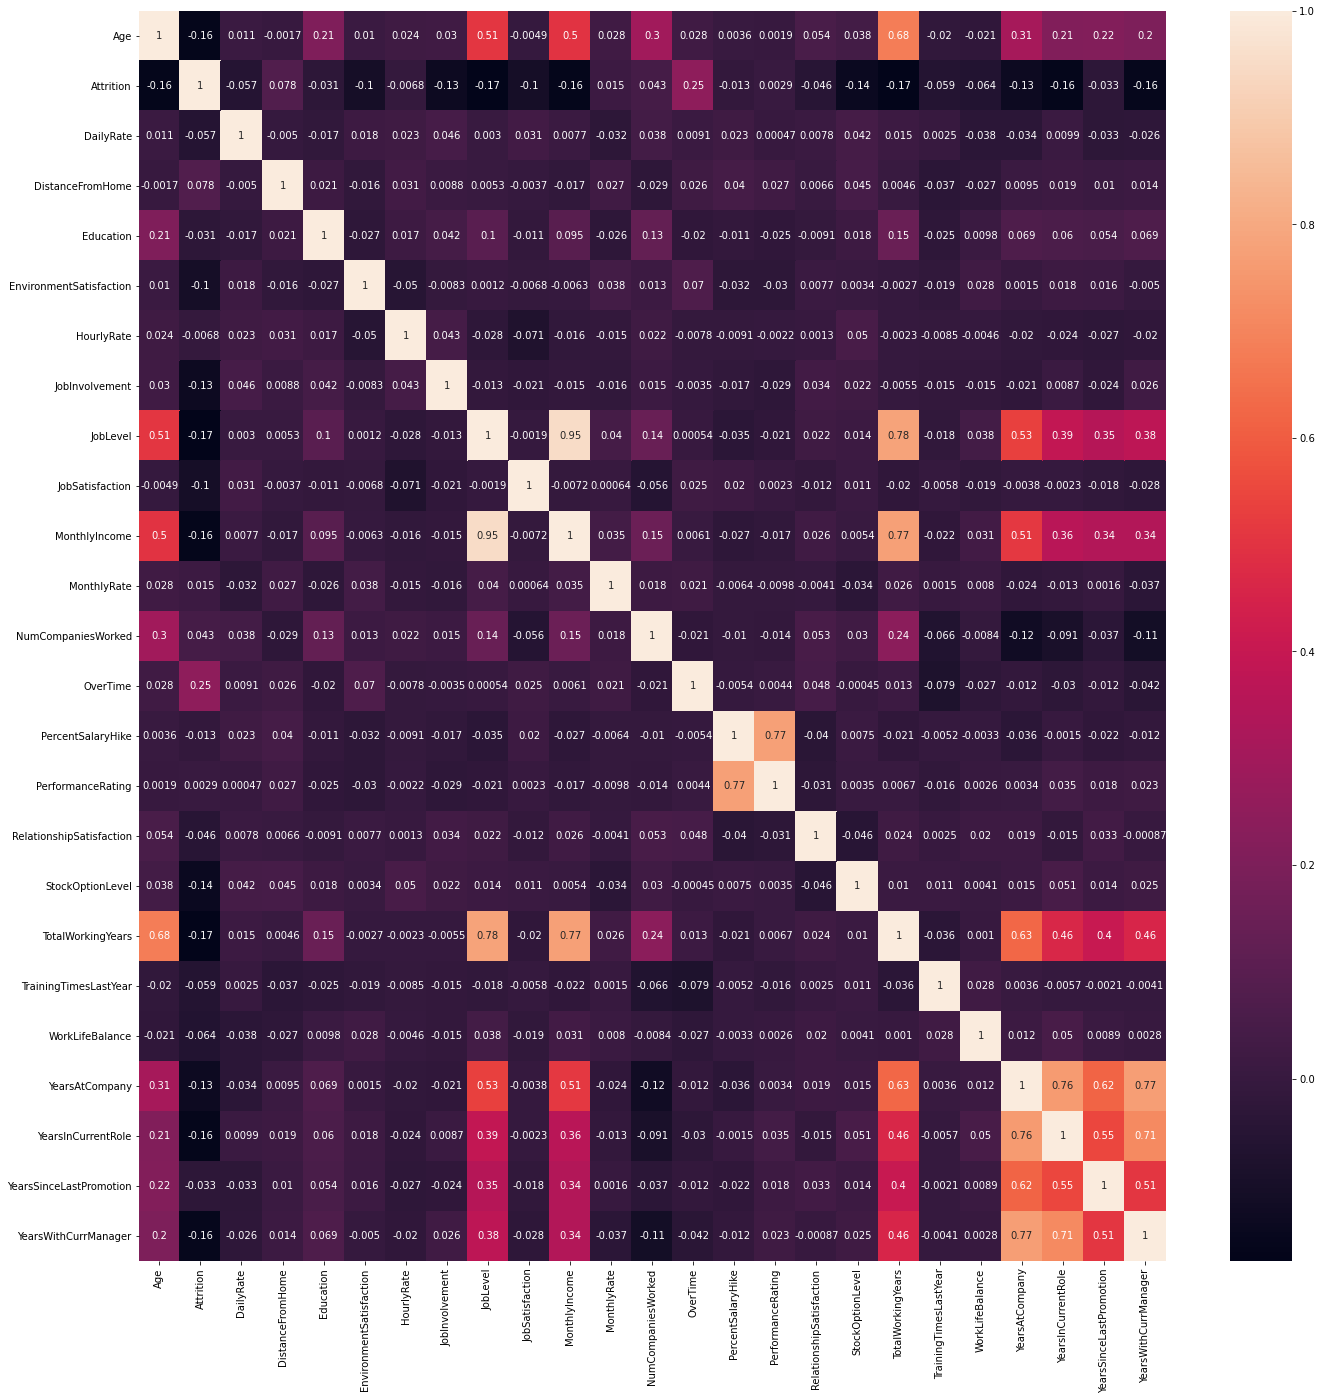

In [15]:
# Mapa de correlações dos atributos da base
corr = df.corr()
f, ax = plt.subplots(figsize = (23,23))
sns.heatmap(corr, annot=True);

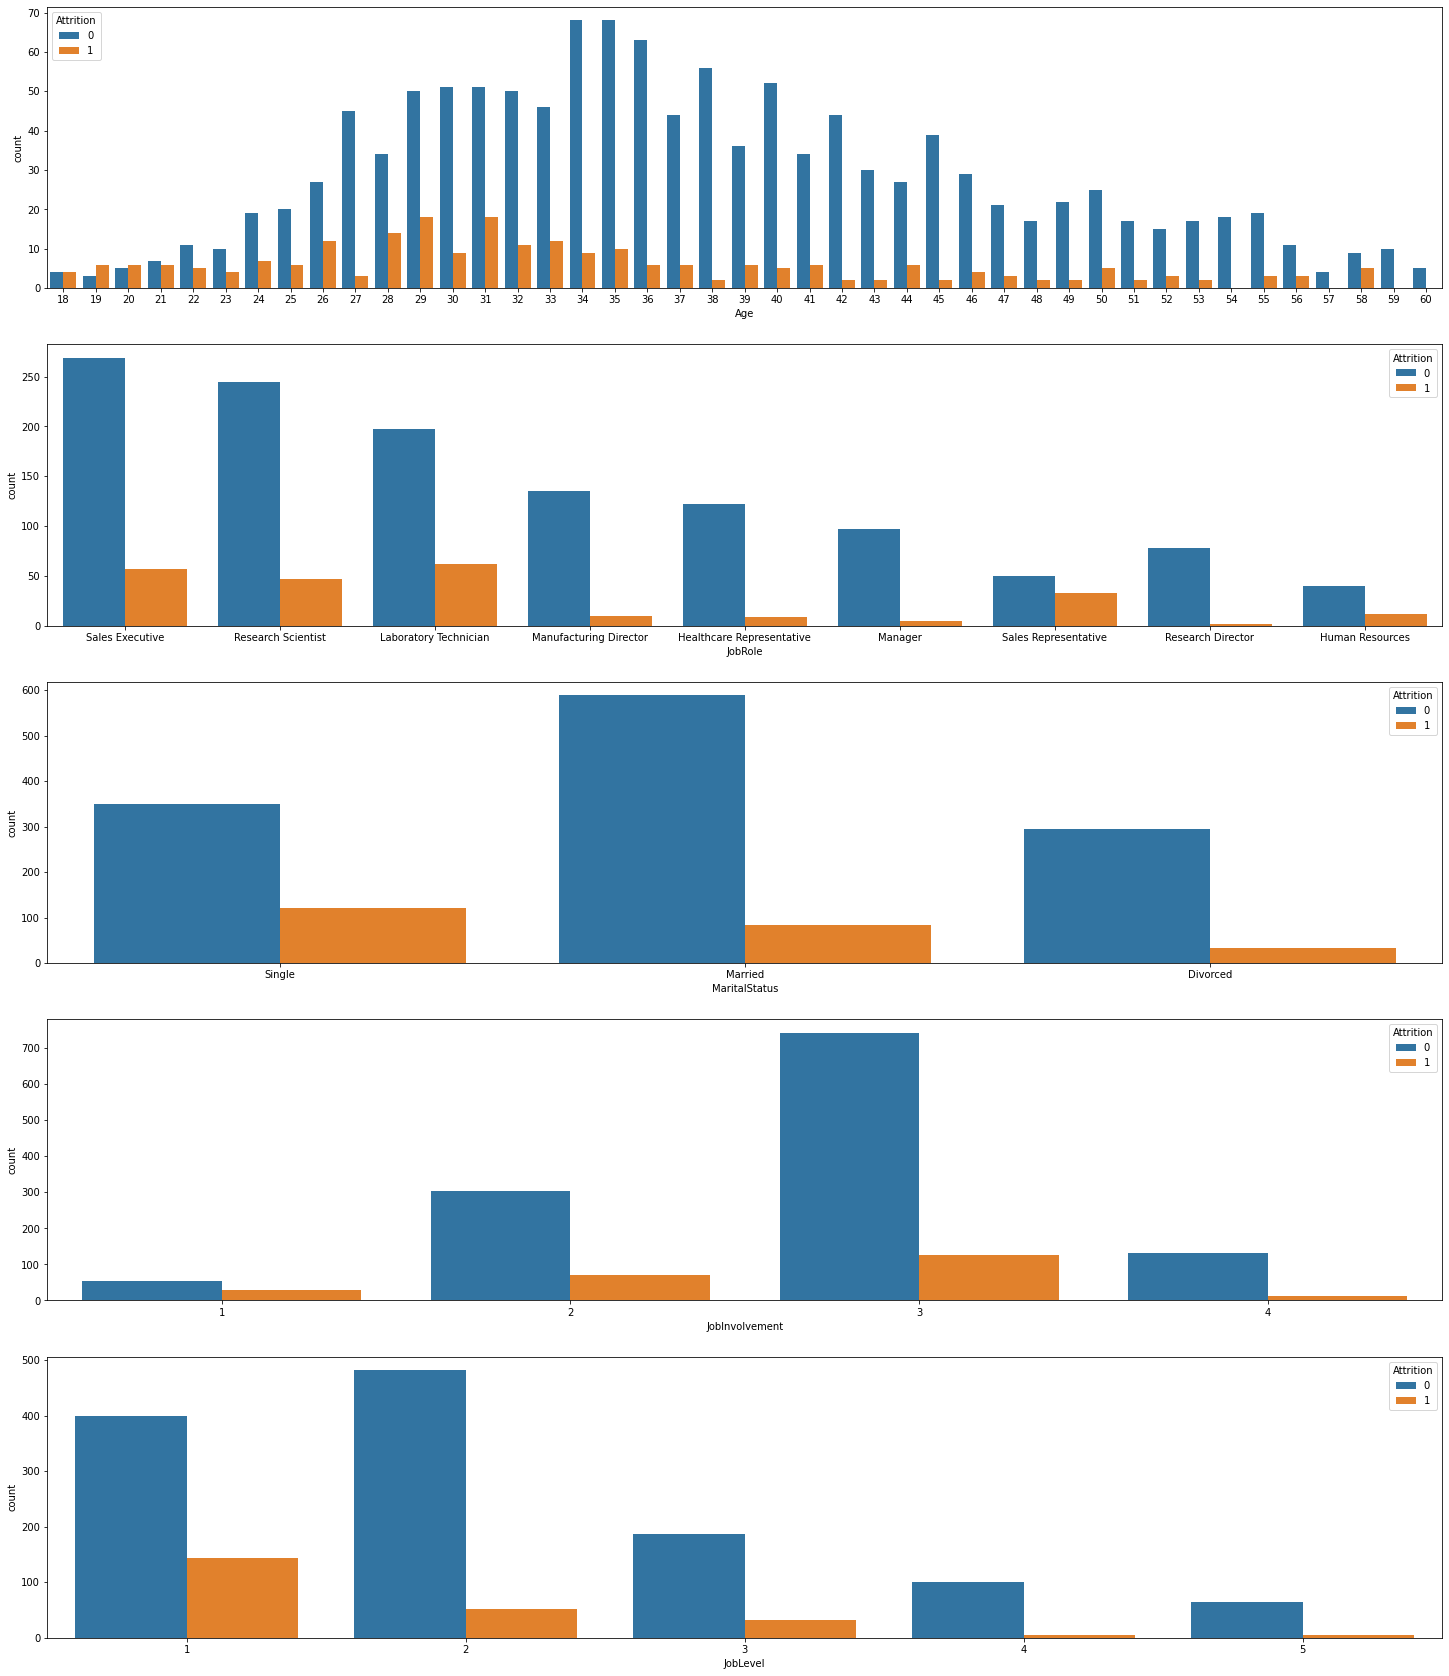

In [16]:
# Gráfico sobre alguns atributos e a probabilidade de sair da empresa
plt.figure(figsize=[25,30]);
plt.subplot(511)
sns.countplot(x = 'Age', hue = 'Attrition', data=df)
plt.subplot(512)
sns.countplot(x = 'JobRole', hue = 'Attrition', data = df)
plt.subplot(513)
sns.countplot(x = 'MaritalStatus', hue = 'Attrition', data = df)
plt.subplot(514)
sns.countplot(x = 'JobInvolvement', hue = 'Attrition', data = df)
plt.subplot(515)
sns.countplot(x = 'JobLevel', hue = 'Attrition', data = df)

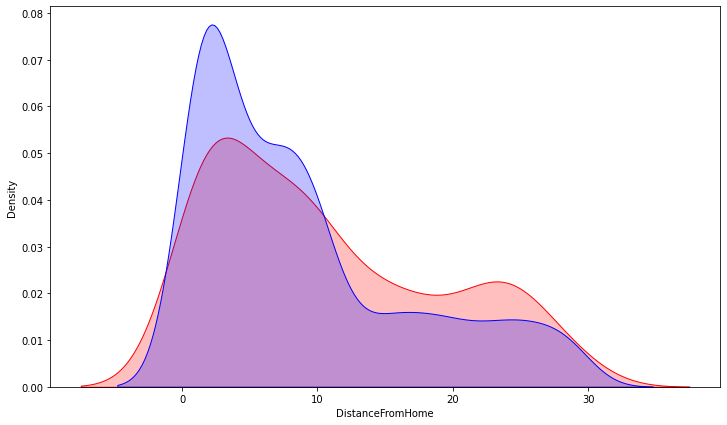

In [17]:
# Gráfico da densidade das estimativas sobre a distância da casa do funcionário para a empresa
# KDE (Kernel Density Estimate)
plt.figure(figsize=(12,7))
sns.kdeplot(sai_df['DistanceFromHome'], label = 'Funcionários que saíram', shade = True, color = 'r')
sns.kdeplot(nSai_df['DistanceFromHome'], label = 'Funcionários que ficaram', shade = True, color = 'b');

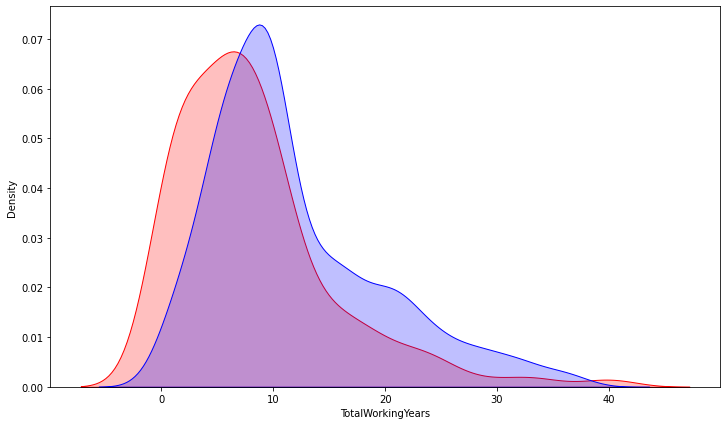

In [18]:
# Gráfico da densidade das estimativas sobre o total de anos trabalhados da vida de um funcionário
plt.figure(figsize=(12,7))
sns.kdeplot(sai_df['TotalWorkingYears'], label = 'Funcionários que saíram', shade = True, color = 'r')
sns.kdeplot(nSai_df['TotalWorkingYears'], label = 'Funcionários que ficaram', shade = True, color = 'b');

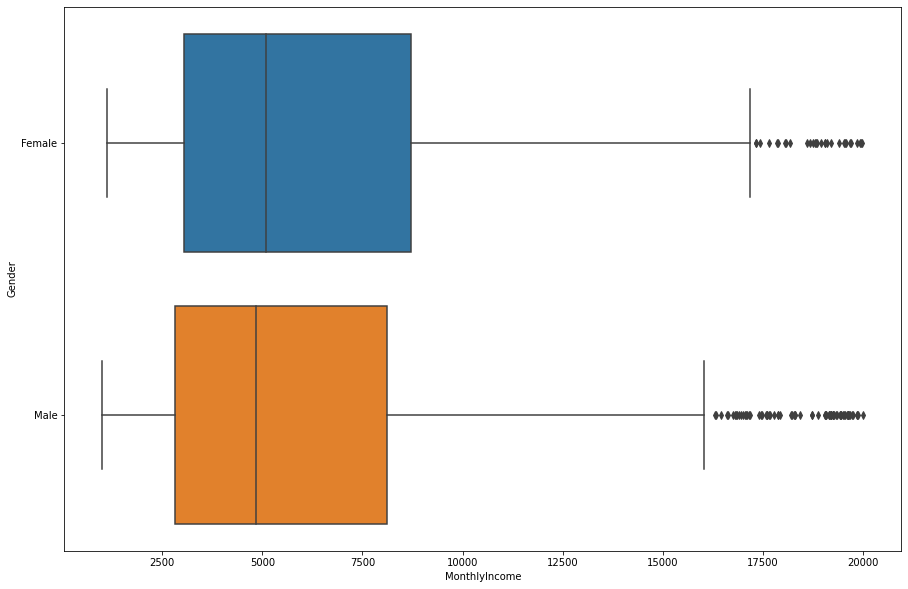

In [19]:
# Boxplot da renda mensal por gênero dos funcionários
plt.figure(figsize=(15, 10))
sns.boxplot(x = 'MonthlyIncome', y = 'Gender', data=df);

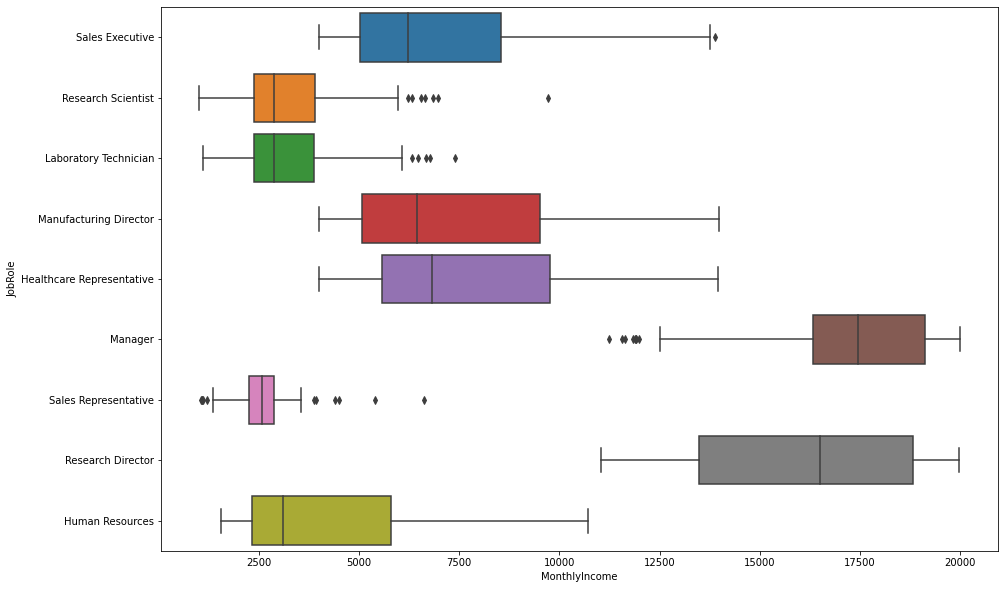

In [20]:
# Boxplot da renda mensal por cargo dos funcionários
plt.figure(figsize=(15, 10))
sns.boxplot(x = 'MonthlyIncome', y = 'JobRole', data=df);

## Pré-processamento

In [21]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,1,11,3,1,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,0,23,4,4,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,1,15,3,2,0,7,3,3,0,0,0,0
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,1,11,3,3,0,8,3,3,8,7,3,0
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,0,12,3,4,1,6,3,3,2,2,2,2


In [22]:
# Pegando apenas os atributos categóricos
X_cat = df[['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']]
X_cat

,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus
0,Travel_Rarely,Sales,Life Sciences,Female,Sales Executive,Single
1,Travel_Frequently,Research & Development,Life Sciences,Male,Research Scientist,Married
2,Travel_Rarely,Research & Development,Other,Male,Laboratory Technician,Single
3,Travel_Frequently,Research & Development,Life Sciences,Female,Research Scientist,Married
4,Travel_Rarely,Research & Development,Medical,Male,Laboratory Technician,Married
...,...,...,...,...,...,...
1465,Travel_Frequently,Research & Development,Medical,Male,Laboratory Technician,Married
1466,Travel_Rarely,Research & Development,Medical,Male,Healthcare Representative,Married
1467,Travel_Rarely,Research & Development,Life Sciences,Male,Manufacturing Director,Married
1468,Travel_Frequently,Sales,Medical,Male,Sales Executive,Married


In [23]:
# Aplicando a tranformação one-hot nos dados categóticos

# Exemplos: 
# Male Female
# 1    0
# 0    1

# Single Married Divorced
# 1      0       0
# 0      1       0
# 0      0       1

from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder()
X_cat = onehotencoder.fit_transform(X_cat).toarray()

X_cat.shape

(1470, 26)

In [24]:
# Transformando em um Dataframe
X_cat = pd.DataFrame(X_cat)

In [25]:
X_cat

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1466,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1467,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1468,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [26]:
# Pegando apenas os atributos numéricos
X_num = df[['Age', 'DailyRate', 'DistanceFromHome',	'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement',	'JobLevel',	'JobSatisfaction',	'MonthlyIncome',	'MonthlyRate',	'NumCompaniesWorked',	'OverTime',	'PercentSalaryHike', 'PerformanceRating',	'RelationshipSatisfaction',	'StockOptionLevel',	'TotalWorkingYears'	,'TrainingTimesLastYear'	, 'WorkLifeBalance',	'YearsAtCompany'	,'YearsInCurrentRole', 'YearsSinceLastPromotion',	'YearsWithCurrManager']]
X_num

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1102,1,2,2,94,3,2,4,5993,19479,8,1,11,3,1,0,8,0,1,6,4,0,5
1,49,279,8,1,3,61,2,2,2,5130,24907,1,0,23,4,4,1,10,3,3,10,7,1,7
2,37,1373,2,2,4,92,2,1,3,2090,2396,6,1,15,3,2,0,7,3,3,0,0,0,0
3,33,1392,3,4,4,56,3,1,3,2909,23159,1,1,11,3,3,0,8,3,3,8,7,3,0
4,27,591,2,1,1,40,3,1,2,3468,16632,9,0,12,3,4,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,884,23,2,3,41,4,2,4,2571,12290,4,0,17,3,3,1,17,3,3,5,2,0,3
1466,39,613,6,1,4,42,2,3,1,9991,21457,4,0,15,3,1,1,9,5,3,7,7,1,7
1467,27,155,4,3,2,87,4,2,2,6142,5174,1,1,20,4,2,1,6,0,3,6,2,0,3
1468,49,1023,2,3,4,63,2,2,2,5390,13243,2,0,14,3,4,0,17,3,2,9,6,0,8


In [27]:
# Concatenando em um só dataframe
X_ = pd.concat([X_cat, X_num], axis = 1)
X_

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,41,1102,1,2,2,94,3,2,4,5993,19479,8,1,11,3,1,0,8,0,1,6,4,0,5
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,49,279,8,1,3,61,2,2,2,5130,24907,1,0,23,4,4,1,10,3,3,10,7,1,7
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,37,1373,2,2,4,92,2,1,3,2090,2396,6,1,15,3,2,0,7,3,3,0,0,0,0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,33,1392,3,4,4,56,3,1,3,2909,23159,1,1,11,3,3,0,8,3,3,8,7,3,0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,27,591,2,1,1,40,3,1,2,3468,16632,9,0,12,3,4,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,36,884,23,2,3,41,4,2,4,2571,12290,4,0,17,3,3,1,17,3,3,5,2,0,3
1466,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,39,613,6,1,4,42,2,3,1,9991,21457,4,0,15,3,1,1,9,5,3,7,7,1,7
1467,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,27,155,4,3,2,87,4,2,2,6142,5174,1,1,20,4,2,1,6,0,3,6,2,0,3
1468,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,49,1023,2,3,4,63,2,2,2,5390,13243,2,0,14,3,4,0,17,3,2,9,6,0,8


In [28]:
# Fazendo minmaxscaler nos dados
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X_)
X

array([[0.        , 0.        , 1.        , ..., 0.22222222, 0.        ,
        0.29411765],
       [0.        , 1.        , 0.        , ..., 0.38888889, 0.06666667,
        0.41176471],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 1.        , ..., 0.11111111, 0.        ,
        0.17647059],
       [0.        , 1.        , 0.        , ..., 0.33333333, 0.        ,
        0.47058824],
       [0.        , 0.        , 1.        , ..., 0.16666667, 0.06666667,
        0.11764706]])

In [29]:
# O dado que quero prever
y = df['Attrition']
y

0       1
1       0
2       1
3       0
4       0
       ..
1465    0
1466    0
1467    0
1468    0
1469    0
Name: Attrition, Length: 1470, dtype: int64

In [30]:
# Dividindo a base em 25% pra teste e o resto pra treino
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

## Previsões

### Regressão logística

In [31]:
# Fase de treino
logistic = LogisticRegression()
logistic.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
# Fase de teste
y_pred = logistic.predict(X_test)

In [33]:
# Cálculo da acurácia
accuracy_score(y_test, y_pred)

0.8777173913043478

In [34]:
# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
cm

array([[302,   7],
       [ 38,  21]])

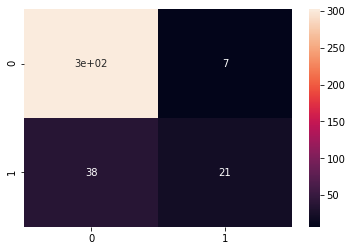

In [35]:
# Matriz de confusão
sns.heatmap(cm, annot=True);

In [36]:
# Precisão
precision_score(y_test, y_pred)

0.75

In [37]:
# Recall
recall_score(y_test, y_pred)

0.3559322033898305

In [38]:
# F1_score
f1_score(y_test, y_pred, average='macro')

0.7067105892354285

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       309
           1       0.75      0.36      0.48        59

    accuracy                           0.88       368
   macro avg       0.82      0.67      0.71       368
weighted avg       0.87      0.88      0.86       368



### KNN

In [74]:
# Fase de treino
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [75]:
# Fase de teste
y_pred = neigh.predict(X_test)

In [76]:
# Cálculo da acurácia
accuracy_score(y_test, y_pred)

0.842391304347826

In [77]:
# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
cm

array([[300,   9],
       [ 49,  10]])

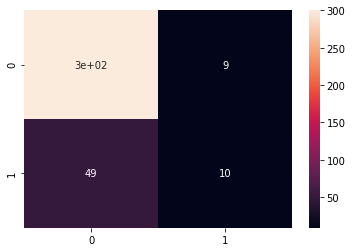

In [78]:
# Matriz de confusão
sns.heatmap(cm, annot=True);

In [79]:
# Precisão
precision_score(y_test, y_pred)

0.5263157894736842

In [80]:
# Recall
recall_score(y_test, y_pred)

0.1694915254237288

In [81]:
# F1_score
f1_score(y_test, y_pred, average='macro')

0.5841321798768606

In [82]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91       309
           1       0.53      0.17      0.26        59

    accuracy                           0.84       368
   macro avg       0.69      0.57      0.58       368
weighted avg       0.81      0.84      0.81       368



### Random forest

In [40]:
# Fase de treino
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [41]:
# Fase de teste
y_pred = forest.predict(X_test)

In [42]:
# Acurácia
accuracy_score(y_test, y_pred)

0.8559782608695652

In [43]:
# Precisão
precision_score(y_test, y_pred)

0.8

In [44]:
# Recall
recall_score(y_test, y_pred)

0.13559322033898305

In [45]:
# F1_score
f1_score(y_test, y_pred, average='macro')

0.5762118940529735

In [46]:
# Matriz de confusão
cm = confusion_matrix(y_pred, y_test)
cm

array([[307,  51],
       [  2,   8]])

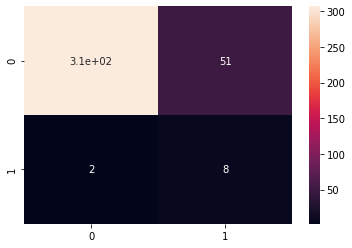

In [47]:
# Matriz de confusão
sns.heatmap(cm, annot=True);

In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       309
           1       0.80      0.14      0.23        59

    accuracy                           0.86       368
   macro avg       0.83      0.56      0.58       368
weighted avg       0.85      0.86      0.81       368



### Redes neurais

In [49]:
# Cálculo para escolha de 25 neurônios
# (50 + 1) / 2

# Construção da rede
rn = tf.keras.models.Sequential()
rn.add(tf.keras.layers.Dense(units = 25, activation='relu', input_shape=(50,)))
rn.add(tf.keras.layers.Dense(units = 25, activation = 'relu'))
#rn.add(tf.keras.layers.Dense(units = 25, activation = 'relu'))
rn.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))

In [50]:
rn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 25)                650       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 1,951
Trainable params: 1,951
Non-trainable params: 0
_________________________________________________________________


In [51]:
# Compilando o modelo
rn.compile(optimizer='Adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [52]:
# Fase de treino
rn.fit(X_train, y_train, epochs=150)

Epoch 1/150
35/35 [==============================] - 0s 1ms/step - loss: 0.5578 - accuracy: 0.7586
Epoch 2/150
35/35 [==============================] - 0s 1ms/step - loss: 0.4378 - accuracy: 0.8385
Epoch 3/150
35/35 [==============================] - 0s 1ms/step - loss: 0.4184 - accuracy: 0.8385
Epoch 4/150
35/35 [==============================] - 0s 1ms/step - loss: 0.4020 - accuracy: 0.8385
Epoch 5/150
35/35 [==============================] - 0s 1ms/step - loss: 0.3860 - accuracy: 0.8394
Epoch 6/150
35/35 [==============================] - 0s 1ms/step - loss: 0.3713 - accuracy: 0.8475
Epoch 7/150
35/35 [==============================] - 0s 1ms/step - loss: 0.3582 - accuracy: 0.8566
Epoch 8/150
35/35 [==============================] - 0s 1ms/step - loss: 0.3479 - accuracy: 0.8584
Epoch 9/150
35/35 [==============================] - 0s 1ms/step - loss: 0.3414 - accuracy: 0.8593
Epoch 10/150
35/35 [==============================] - 0s 1ms/step - loss: 0.3329 - accuracy: 0.8648
Epoch 11/

In [53]:
# Fase de teste
y_pred = rn.predict(X_test)

# Valores acima de 0.5 são 1 e abaixo são 0
y_pred = (y_pred >= 0.5)

In [54]:
# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
cm

array([[280,  29],
       [ 34,  25]])

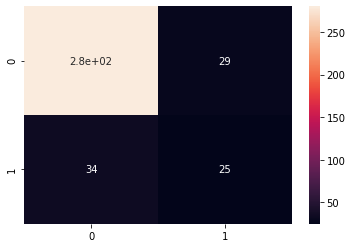

In [55]:
# Matriz de confusão
sns.heatmap(cm, annot=True);

In [56]:
# Acurácia
accuracy_score(y_test, y_pred)

0.8288043478260869

In [57]:
# Precisão
precision_score(y_test, y_pred)

0.46296296296296297

In [58]:
# Recall
recall_score(y_test, y_pred)

0.423728813559322

In [59]:
# F1_score
f1_score(y_test, y_pred, average='macro')

0.6706771403002884

In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       309
           1       0.46      0.42      0.44        59

    accuracy                           0.83       368
   macro avg       0.68      0.66      0.67       368
weighted avg       0.82      0.83      0.83       368



## Salvando o classificador para futuras previsões

In [61]:
# Apenas para os modelos do sklearn, e não do tensorflow

with open('variaveis_modelo.pkl', 'wb') as f:
  pickle.dump([scaler, onehotencoder, logistic], f)

In [62]:
with open('variaveis_modelo.pkl', 'rb') as f:
  min_max, encoder, model = pickle.load(f)

## Testando com "novos" funcionários

In [63]:
# Novos funcionários
X_novo = df.iloc[121:123]
X_novo = X_novo.reset_index()
X_novo = X_novo.drop(['index'], axis=1)
X_novo

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,33,0,Non-Travel,750,Sales,22,2,Marketing,3,Male,95,3,2,Sales Executive,2,Married,6146,15480,0,0,13,3,1,1,8,2,4,7,7,0,7
1,56,1,Travel_Rarely,441,Research & Development,14,4,Life Sciences,2,Female,72,3,1,Research Scientist,2,Married,4963,4510,9,1,18,3,1,3,7,2,3,5,4,4,3


In [64]:
# Atributos categóricos
X_cat_novo = X_novo[['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']]
X_cat_novo

,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus
0,Non-Travel,Sales,Marketing,Male,Sales Executive,Married
1,Travel_Rarely,Research & Development,Life Sciences,Female,Research Scientist,Married


In [65]:
# One-hot
X_cat_novo = encoder.transform(X_cat_novo).toarray()
X_cat_novo = pd.DataFrame(X_cat_novo)
X_cat_novo

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [66]:
# Atributos Numéricos
X_num_novo = X_novo[['Age', 'DailyRate', 'DistanceFromHome',	'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement',	'JobLevel',	'JobSatisfaction',	'MonthlyIncome',	'MonthlyRate',	'NumCompaniesWorked',	'OverTime',	'PercentSalaryHike', 'PerformanceRating',	'RelationshipSatisfaction',	'StockOptionLevel',	'TotalWorkingYears'	,'TrainingTimesLastYear'	, 'WorkLifeBalance',	'YearsAtCompany'	,'YearsInCurrentRole', 'YearsSinceLastPromotion',	'YearsWithCurrManager']]
X_num_novo

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,33,750,22,2,3,95,3,2,2,6146,15480,0,0,13,3,1,1,8,2,4,7,7,0,7
1,56,441,14,4,2,72,3,1,2,4963,4510,9,1,18,3,1,3,7,2,3,5,4,4,3


In [67]:
# Concatenando
X__novo = pd.concat([X_cat_novo, X_num_novo], axis = 1)
X__novo

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,33,750,22,2,3,95,3,2,2,6146,15480,0,0,13,3,1,1,8,2,4,7,7,0,7
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,56,441,14,4,2,72,3,1,2,4963,4510,9,1,18,3,1,3,7,2,3,5,4,4,3


In [68]:
# MinMax
X_novo = min_max.transform(X__novo)

In [69]:
# Fase de teste
model.predict(X_novo)

array([0, 0])

In [70]:
# Propabilidades
model.predict_proba(X_novo)

array([[0.97101261, 0.02898739],
       [0.64459231, 0.35540769]])

In [71]:
# Classes reais
model.classes_

# Errou o segundo, e acertou o primeiro

array([0, 1])